In [1]:
'''
This script is used to genereate tuning files from laser data for the DGA_simulator.
'''

%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sys
import pandas as pd
import os
import ipdb

sys.path.append(r'C:\Data\Python\Characterisation_Report_scripts\src\analysis')
import functions
import overview_tuning

plt.style.use(r"C:\Data\Python\Characterisation_Report_scripts\src\beamer_style.mplstyle")

In [2]:
class tuning():
    '''
    This class generates tuning files from laser data. 
    example use:
    tuning(input file_path, ouput file_path,0,0)
    '''
    def __init__(self,overview_instance_file,output_file,mode,direction):
        '''
        loads data, generates linehsapes and saves it a pickle file. 
        @param overview_instance_file: path to the laser data file.
        @param output_file: file path to the ouput file. (must be .pck for import in DGA_simulator)
        @param mode: 0 for data before mode hop, 1 for data after modehop
        @type mode: int
        @param direction: 0 for upwards scan, 1 for downwards scan
        @type order: int
        '''
        self.load_file(overview_instance_file)
        self.get_modes()
        self.get_tuning(mode,direction)
        self.get_power(direction)
        self.smooth_power(5,3)
        #self.save_file(output_file)
        
        
    
    def load_file(self,file_name):
        '''
        loads data and generates a Dataframe with the tuning. 
        
        @param file_name: Path of the input file. 
        '''
        self.overview_instance=overview_tuning.overview_tuning(file_name,measurement_index=-1)
    
    def get_modes(self):
        '''
        gets the indexes of the modes as a 2D array.
        For each mode, the array contains an entry with two elements: The first and the last element of the mode
        '''
        idx=0
        self.up_modes=np.empty([0,2],dtype=int)
        self.down_modes=np.empty([0,2],dtype=int)
        mode=np.empty(2,dtype=int)
        self.nr_modes=np.zeros(2,dtype=int)
        ################################################
        #das funktioniert noch ueberhaupt nicht!!!!!!!!!!!
        ###################################################
        
        
        while idx<self.overview_instance.data.D1scan_steps/2-1:
            if np.isnan(self.overview_instance.max_Wavelength[idx]):
                idx+=1
            else:
                mode[0]=idx
                while ~np.isnan(self.overview_instance.max_Wavelength[idx]):
                    idx+=1
                    if idx==self.overview_instance.data.D1scan_steps/2-1:
                        #upwards scan finished
                        break
                mode[1]=idx-1
                self.up_modes=np.concatenate([self.up_modes,np.atleast_2d(mode.copy())],axis=0)
                self.nr_modes[0]+=1
        idx+=1 #start with the upwards scan        
        while idx<self.overview_instance.data.D1scan_steps-1:
            if np.isnan(self.overview_instance.max_Wavelength[idx]):
                idx+=1
            else:
                mode[0]=idx
                while ~np.isnan(self.overview_instance.max_Wavelength[idx]):
                    idx+=1
                    if idx==self.overview_instance.data.D1scan_steps-1:
                        #downwards scan finished
                        break
                mode[1]=idx-1
                self.down_modes=np.concatenate([self.down_modes,np.atleast_2d(mode.copy())],axis=0)
                self.nr_modes[1]+=1
            
    
    def get_tuning(self,mode, direction):
        '''
        selects the region to use
        
        @param mode: 0 for data before mode hop, 1 for data after modehop
        @type mode: int
        @param direction: 0 for upwards scan, 1 for downw scan
        @type order: int
        '''
        self.mode_selected=mode
        self.direction=direction
        self.up_list_wl=list()
        self.down_list_wl=list()
        self.up_list_piezo=list()
        self.down_list_piezo=list()
        
        
        #wellenlaengen und piezo spannungen des aufwaertsscan
        for mode in self.up_modes:
            self.up_list_wl.append(self.overview_instance.max_Wavelength_fitted[mode[0]:mode[1]+1])
            self.up_list_piezo.append(self.overview_instance.data.D1scan_values[mode[0]:mode[1]+1])
   
        #vom abwaertsscan
        for mode in self.down_modes:
            self.down_list_wl.append(self.overview_instance.max_Wavelength_fitted[mode[0]:mode[1]+1])
            self.down_list_piezo.append(self.overview_instance.data.D1scan_values[mode[0]:mode[1]+1])
  
        
        #get tuning depending on selected region
        
        if direction==0:
            try:
                wl_list=self.up_list_wl[self.mode_selected]
                x_list=self.up_list_piezo[self.mode_selected]
            except IndexError:
                print 'note enough modes found, please choose lower mode'
                return
        elif direction==1:
            try:
                wl_list=self.down_list_wl[self.mode_selected]
                x_list=self.down_list_piezo[self.mode_selected]
            except IndexError:
                print 'note enough modes found, please choose lower mode'
                return
    
        self.tuning_df=pd.DataFrame({'piezo':x_list,'wavelength':wl_list})
        
    def get_power(self,direction=0):
        
        self.up_list_power=list()
        self.down_list_power=list()
        #get power depending on selected region
        for mode in self.up_modes:
            self.up_list_power.append(self.overview_instance.max_Power[mode[0]:mode[1]+1])
        for mode in self.down_modes:
            self.down_list_power.append(self.overview_instance.max_Power[mode[0]:mode[1]+1])

            
        if len(self.up_list_power)>1:
        #normalize part before and after mode hope
        #it takes all values from the first mode and rejects the values from the second mode which overlap with the first mode
            if direction==0:
                if len(self.up_list_power)>1:
                    #overlap region
                    overlap=self.up_list_wl[1]>self.up_list_wl[0][0]

                    #normalize the power of the two modes in the overlap region
                    factor=self.up_list_power[1][overlap].mean()/self.up_list_power[0][:overlap.sum()].mean()

                    #concatenate the two normalized modes 
                    power_array=np.concatenate((self.up_list_power[1][~overlap]/factor,self.up_list_power[0]))
                    wl_array=np.concatenate((self.up_list_wl[1][~overlap],self.up_list_wl[0]))

            elif direction==1:
                if len(self.down_list_power)>1:
                    #overlap region
                    overlap=self.up_list_wl[1]>self.up_list_wl[0]

                    #normalize the power of the two modes in the overlap region
                    factor=self.down_list_power[1][overlap].mean()/self.down_list_power[0][:overlap.sum()].mean()

                    #concatenate the two normalized modes 
                    power_array=np.concatenate((self.down_list_power[1][~overlap]/factor,self.down_list_power[0]))
                    wl_array=np.concatenate((self.down_list_wl[1][~overlap],self.down_list_wl[0]))
            
            
            #sort by wavelength  
            sort=np.argsort(wl_array)
            power_array=power_array[sort]
            wl_array=wl_array[sort]
        
        else:
            #only one mode present
            if direction==0:
                power_array=self.up_list_power[0]
                wl_array=self.up_list_wl[0]
            elif direction==1:
                power_array=self.down_list_power[0]
                wl_array=self.down_list_wl[0]
                
                
            

        '''
        #filter array
        filter_array=np.isfinite(x_list) 
        y_list=y_list[filter_array]
        x_list=x_list[filter_array]
        #sort array
        sort_array=np.argsort(x_list)
        y_list=y_list[sort_array]
        x_list=x_list[sort_array]
        '''
        #nan=0
        wl_array[np.isnan(wl_array)]=0
        self.power_df=pd.DataFrame({'wavelength_power':wl_array,'power':power_array})
        
    
    def smooth_power(self,window_size, order):
        '''
        smooths powers with a savitzky_golay filter.
        
        @param window_size: the length of the window. Must be an odd integer number.
        @type window_size: int
        @param order: the order of the polynomial used in the filtering.
                        Must be less then `window_size` - 1
        @type order: int
        '''
        #get zero filling depending on selected region

        if self.mode_selected==0:
            if self.direction==0:
                begin_fill=np.repeat([self.power_df['power'].values[0]],2*window_size)
                end_fill=np.zeros(2*window_size)
            else:
                begin_fill=np.zeros(2*window_size)
                end_fill=np.repeat([self.power_df['power'].values[-1]],2*window_size)
        elif self.mode==1:
            if self.direction==0:
                begin_fill=np.repeat([self.power_df['power'].values[-1]],2*window_size)
                end_fill=np.zeros(2*window_size)
            else:
                begin_fill=np.zeros(2*window_size)
                end_fill=np.repeat([self.power_df['power'].values[0]],2*window_size)
        
        #zero_fill
        y_array=np.concatenate((begin_fill,self.power_df['power'].values,end_fill))
        #filter
        y_array=functions.savitzky_golay(y_array,window_size,order)
        #remove zero_fill
        y_array=y_array[2*window_size-1:-2*window_size-1]
        self.power_df['power']=y_array
        
            
    def save_file(self,file_name):
        '''
        saves the tuning as a pandas Dataframe pickle.
        @param file_name: path to the ouput file
        '''
        self.data_frame=pd.concat([self.tuning_df, self.power_df], axis=1)
        self.data_frame.to_pickle(file_name)
    
    def plot_tuning(self):
        '''
        plots the lineshapes.
        '''
        fig, ax=plt.subplots(1)
        ax.plot(self.tuning_df['piezo'],self.tuning_df['wavelength'])
        plt.show()
    def plot_power(self):
        fig, ax=plt.subplots(1)
        ax.plot(self.power_df['wavelength_power'],self.power_df['power'])
        plt.show()
        

In [3]:
ls=tuning(r"C:\Data\Results\Auto_measurements\PN-12-003-SN0001(back_from_UK)\overview_tuning.txt",r"C:\Users\CTCHguest\Desktop\report\tuning_3.pck",0,0)

In [25]:
ls=tuning(r"C:\Data\Results\Auto_measurements\PN-12-024-SN0001\DGA_lineshape.txt",r"C:\Data\Python\DGA_simulator\sample_laser_files\PN-12-024-SN0001_tuning.pck",0,0)

In [9]:
ls.down_modes

array([[ 64,  96],
       [102, 126]])

In [10]:
ls.overview_instance.max_Wavelength[64:96+2]

array([ 3378.5696,  3376.1687,  3374.3577,  3371.9561,  3369.5457,
        3367.1428,  3364.739 ,  3362.3267,  3360.5295,  3357.5161,
        3355.1106,  3352.1042,  3349.0969,  3345.4883,  3342.479 ,
        3338.876 ,  3334.6626,  3330.4551,  3326.2385,  3322.0281,
        3317.823 ,  3313.0063,  3307.5928,  3302.7795,  3297.3679,
        3292.5571,  3287.7439,  3282.3328,  3276.3137,  3270.2991,
        3264.2888,  3257.6697,  3251.0537,        nan])

In [69]:
ls.overview_instance.max_Wavelength[33]

3445.3389000000002

<IPython.core.display.Javascript object>


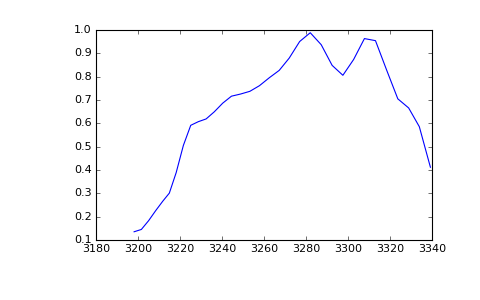

In [27]:
ls.plot_power()

<IPython.core.display.Javascript object>


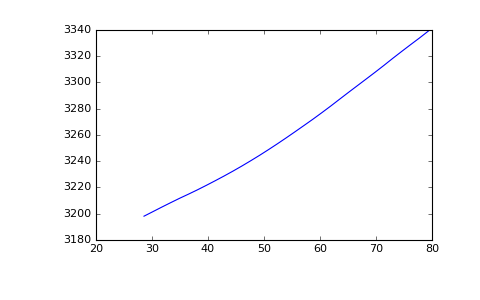

In [15]:
ls.plot_tuning()

In [4]:
ls.tuning_df

piezo   wavelength
0    0.000000  3350.387167
1    1.587302  3352.984576
2    3.174603  3355.806949
3    4.761905  3358.479048
4    6.349206  3361.303068
5    7.936508  3363.972409
6    9.523810  3366.516657
7   11.111111  3369.144680
8   12.698413  3371.529781
9   14.285714  3373.964825
10  15.873016  3376.400310
11  17.460317  3378.937119
12  19.047619  3381.409682
13  20.634921  3384.020615
14  22.222222  3386.661171
15  23.809524  3389.315767
16  25.396825  3392.106733
17  26.984127  3394.895434
18  28.571429  3397.664626
19  30.158730  3400.614669
20  31.746032  3403.554948
21  33.333333  3406.524573
22  34.920635  3409.790145
23  36.507937  3413.067711
24  38.095238  3416.296097
25  39.682540  3419.800201
26  41.269841  3423.395831
27  42.857143  3427.166122
28  44.444444  3431.057953
29  46.031746  3434.959438
30  47.619048  3438.429497
31  49.206349  3441.552855
32  50.793651  3444.658115
33  52.380952  3445.326276

In [8]:
ls.get_tuning(0,0)

In [14]:
ls.nanpositions_up

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

In [11]:
ls.overview_instance.max_Wavelength

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,  3198.1953,  3201.6118,
        3205.0269,  3208.4409,  3211.7273,  3214.8784,  3218.1628,
        3221.573 ,  3225.1238,  3228.665 ,  3232.4736,  3236.2878,
        3240.354 ,  3244.4255,  3248.7634,  3253.2249,  3257.8267,
        3262.4185,  3267.1487,  3272.011 ,  3276.9968,  3281.9873,
        3287.2422,  3292.3616,  3297.4856,  3302.6069,  3307.7261,
        3313.1162,  3318.4954,  3323.6221,  3328.8782,  3333.9988,
        3339.3828,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

In [15]:
ls.up_befor_hop

array([           nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,  3198.1463982 ,  3201.59724691,
        3205.05829849,  3208.44064158,  3211.76694904,  3214.92090522,
        3218.18372858,  3221.59617489,  3225.11444452,  3228.71384085,
        3232.44734085,  3236.32633893,  3240.35543092,  3244.50363229,
        3248.82500082,  3253.2658416 ,  3257.83142024,  3262.5056768 ,
        3267.24421256,  3272.02037871,  3276.9699092 ,  3282.02382837,
        3287.24702883,  3292.44341748,  3297.56186925,  3302.67693485,
        3307.82393704,  3313.08076871,  3318.47713011,  3323.72025023,
        3328.88150816,  3333.96093899,  3339.24416206,            nan,
                  nan,            nan,            nan,            nan,
      

In [16]:
ls.overview_instance.max_Wavelength_fitted[:ls.nanpositions_up[0]-1]

array([           nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,  3198.1463982 ,  3201.59724691,
        3205.05829849,  3208.44064158,  3211.76694904,  3214.92090522,
        3218.18372858,  3221.59617489,  3225.11444452,  3228.71384085,
        3232.44734085,  3236.32633893,  3240.35543092,  3244.50363229,
        3248.82500082,  3253.2658416 ,  3257.83142024,  3262.5056768 ,
        3267.24421256,  3272.02037871,  3276.9699092 ,  3282.02382837,
        3287.24702883,  3292.44341748,  3297.56186925,  3302.67693485,
        3307.82393704,  3313.08076871,  3318.47713011,  3323.72025023,
        3328.88150816,  3333.96093899,  3339.24416206,            nan,
                  nan,            nan,            nan,            nan,
      

In [8]:
ls.overview_instance.max_Wavelength_fitted[103:]

NameError: name 'ls' is not defined

In [18]:
ls.nanpositions_up[0]

0

In [21]:
ls.nanpositions_up

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

In [62]:
up_modes=np.empty([0,2])
down_modes=np.empty([0,2])
mode=np.empty(2)

In [63]:
up_modes

array([], shape=(0, 2), dtype=float64)

In [72]:
mode

array([ 0.,  0.])

In [75]:
up_modes=np.concatenate([up_modes,np.atleast_2d(mode)],axis=0)

In [76]:
up_modes

array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]])